# Electricity Demand Forecast Using Neural Prophet

### Jennifer Rodriguez-Trujillo, Xiangyue Wang
### Summer 2022

Precise electricity demand forecast is a crucial part of ensuring electric grid stability. Since the electric grid has limited capacity to store energy, inaccurate electricity demand forecast could lead to, at best, a waste of unused energy, and, at worst, grid failure that leads to significant economic and potential human loss.

In this project, given daily data points of electricity demand and price from January 1st, 2015 to October 6, 2020, for Victoria, Australia, we want to examine and forecast energy demand and energy prices. We will conduct a time series forecast using Meta’s NeuralProphets, which is a hybrid forecasting model based in AR-net. We will also perform hyperparameter tuning on the model and benchmark it against other forecasting strategies such as Predict Last Value, Exponential Smoothing, and SARIMA.

NeuralProphet has a modular composability that consists of various fixed and unfixed modules. That each contribute to forecasting.

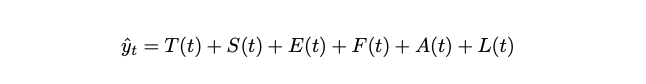

where,

T(t) = Trend at time t <br>
S(t) = Seasonal effects at time t <br>
E(t) = Event and holiday effects at time t <br>
F(t) = Regression effects at time t for future-known exogenous variables <br>
A(t) = Auto-regression effects at time t based on past observations <br>
L(t) = Regression effects at time t for lagged observations of exogenous variables <br>
<br>
Here, trend and seasonality are the only modules activated by default. 

## Importing libraries

In [98]:
import pandas as pd
import numpy as np
import itertools

import plotly.express as px
import plotly.graph_objects as go
from neuralprophet import NeuralProphet

In [99]:
data = pd.read_csv('complete_dataset.csv')

# Exploratory Analysis

In this dataset, we have 2106 rows of data and 14 columns. The two columns of interest for forecasting are the date and demand columns. <br>

The date column accounts for data by day and spans across 5 years. The demand is measured in kilowatts. <br>


In [100]:
print("'Data' type: ", type(data) )
print("'Data' contains", len(data), "rows.")
print("'Data' contains the following dimensions: ", data.shape)

'Data' type:  <class 'pandas.core.frame.DataFrame'>
'Data' contains 2106 rows.
'Data' contains the following dimensions:  (2106, 14)


#### First Five Rows:

In [101]:
data.head()

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


#### Displaying Data Types:

In [102]:
data.info

<bound method DataFrame.info of             date      demand        RRP  demand_pos_RRP  RRP_positive  \
0     2015-01-01   99635.030  25.633696       97319.240     26.415953   
1     2015-01-02  129606.010  33.138988      121082.015     38.837661   
2     2015-01-03  142300.540  34.564855      142300.540     34.564855   
3     2015-01-04  104330.715  25.005560      104330.715     25.005560   
4     2015-01-05  118132.200  26.724176      118132.200     26.724176   
...          ...         ...        ...             ...           ...   
2101  2020-10-02   99585.835  -6.076028       41988.240     26.980251   
2102  2020-10-03   92277.025  -1.983471       44133.510     32.438156   
2103  2020-10-04   94081.565  25.008614       88580.995     26.571687   
2104  2020-10-05  113610.030  36.764701      106587.375     39.616015   
2105  2020-10-06  122607.560  75.771059      122607.560     75.771059   

      demand_neg_RRP  RRP_negative  frac_at_neg_RRP  min_temperature  \
0           2315.79

#### Basic Statistics:

In [103]:
data.describe()

,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2105.000000,2103.000000
mean,120035.476503,76.079554,119252.305055,76.553847,783.171448,-2.686052,0.008547,11.582289,20.413200,14.743373,1.505944
std,13747.993761,130.246805,14818.631319,130.114184,3578.920686,19.485432,0.039963,4.313711,6.288693,7.945527,4.307897
min,85094.375000,-6.076028,41988.240000,13.568986,0.000000,-342.220000,0.000000,0.600000,9.000000,0.700000,0.000000
25%,109963.650000,38.707040,109246.250000,39.117361,0.000000,0.000000,0.000000,8.500000,15.525000,8.200000,0.000000
50%,119585.912500,66.596738,119148.082500,66.869058,0.000000,0.000000,0.000000,11.300000,19.100000,12.700000,0.000000
75%,130436.006250,95.075012,130119.477500,95.130181,0.000000,0.000000,0.000000,14.600000,23.900000,20.700000,0.800000
max,170653.840000,4549.645105,170653.840000,4549.645105,57597.595000,0.000000,0.625000,28.000000,43.500000,33.300000,54.600000


In [104]:
data.describe(include=object)

,date,school_day,holiday
count,2106,2106,2106
unique,2106,2,2
top,2019-06-13,Y,N
freq,1,1453,2029


#### Checking for Missing Values:

In [105]:
data.isnull().sum()

date               0
demand             0
RRP                0
demand_pos_RRP     0
RRP_positive       0
demand_neg_RRP     0
RRP_negative       0
frac_at_neg_RRP    0
min_temperature    0
max_temperature    0
solar_exposure     1
rainfall           3
school_day         0
holiday            0
dtype: int64

#### Out of the variables above, we are focusing on two variables in particular: date and demand.

In [106]:
date_demand = data[['date','demand']]
date_demand

,date,demand
0,2015-01-01,99635.030
1,2015-01-02,129606.010
2,2015-01-03,142300.540
3,2015-01-04,104330.715
4,2015-01-05,118132.200
...,...,...
2101,2020-10-02,99585.835
2102,2020-10-03,92277.025
2103,2020-10-04,94081.565
2104,2020-10-05,113610.030


In [107]:
date = date_demand['date']
demand = max(date_demand['demand'])

In [108]:
date

0       2015-01-01
1       2015-01-02
2       2015-01-03
3       2015-01-04
4       2015-01-05
           ...    
2101    2020-10-02
2102    2020-10-03
2103    2020-10-04
2104    2020-10-05
2105    2020-10-06
Name: date, Length: 2106, dtype: object

#### Plot of Demand Over Time

In [109]:


fig = px.line(date_demand, x="date", y="demand", title='Date and Demand')
fig.show()

Setting "date" as index to easily select time intervals:

In [110]:
data['date1'] = data['date']
date_demand = data.set_index('date1')
year_2018 = date_demand['2018-01-01' :'2019-01-01']
year_2018.head()

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
date1,,,,,,,,,,,,,,
2018-01-01,2018-01-01,95959.685,71.817747,95959.685,71.817747,0.0,0.0,0.0,16.6,25.3,31.4,0.0,N,Y
2018-01-02,2018-01-02,105277.850,69.387730,105277.850,69.387730,0.0,0.0,0.0,16.4,21.8,29.7,0.0,N,N
2018-01-03,2018-01-03,106373.825,67.238117,106373.825,67.238117,0.0,0.0,0.0,14.6,21.0,27.2,0.0,N,N
2018-01-04,2018-01-04,113337.685,78.738187,113337.685,78.738187,0.0,0.0,0.0,14.1,23.6,31.8,0.2,N,N
2018-01-05,2018-01-05,123247.735,90.828170,123247.735,90.828170,0.0,0.0,0.0,14.7,30.7,31.7,0.0,N,N


In [111]:
year_15_19 = date_demand['2015-01-01' :'2019-12-31']

What caused a spike in electricty demand in March 2019?


# Train | Test | Validation :

Below, we are splitting the data into three time intervals for the purpose of creating test, validation, and training data sets. Specifically, we set the following intervals:<br>
   - 2015 to 2017 as training data<br>
   - 2018 as validation data<br>
   - 2019 as test data <br>

#### Test:

In [112]:
test_19 = date_demand['2019-01-01' :'2019-12-31']
test_19 = test_19[['date', 'demand']]

#### Validation:

In [113]:
val_19 = date_demand['2018-01-01' :'2018-12-31']
val_19 = val_19[['date', 'demand']]

#### Train 

In [114]:
train_19 = date_demand['2015-01-01' :'2017-12-31']
train_19 = train_19[['date', 'demand']]

# Visualization of  Test | Train | Validation :

A graphical representation can be viewed in the following of how the data is split. <br>

In [115]:
# Load data
df = year_15_19

# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter( x= list(df.date), y=list(df.demand)))

# Set title
fig.update_layout(
    title_text="Train | Test | Validation"
)


# Add annotations
fig.update_layout(
    annotations=[
        dict(
            x="2016-07-01",
            y=0,
            arrowcolor="rgba(63, 81, 181, 0.2)",
            arrowsize=0.3,
            ax=0,
            ay=10,
            text="Train",
            xref="x",
            yanchor="bottom",
            yref="y"
        ),
        dict(
            x="2018-07-01",
            y=0,
            arrowcolor="rgba(76, 175, 80, 0.1)",
            arrowsize=0.3,
            ax=0,
            ay=10,
            text="Train | Validation | Test",
            xref="x",
            yanchor="bottom",
            yref="y"
        ),
        dict(
            x="2019-07-01",
            y=0,
            arrowcolor="rgba(76, 175, 80, 0.1)",
            arrowsize=0.3,
            ax=0,
            ay=10,
            text="Test",
            xref="x",
            yanchor="bottom",
            yref="y"
        )
    ],
)

fig.update_layout(
    shapes=[
        dict(
            fillcolor="rgba(390, 81, 181, 0.2)",
            line={"width": 0},
            type="rect",
            x0="2015-01-01",
            x1="2017-12-31",
            xref="x",
            y0=0,
            y1=0.95,
            yref="paper"
        ),
        dict(
            fillcolor="rgba(340, 90, 20, 0.1)",
            line={"width": 0},
            type="rect",
            x0="2018-01-01",
            x1="2018-12-31",
            xref="x",
            y0=0,
            y1=0.95,
            yref="paper"
        ),
        dict(
            fillcolor="rgba(76, 175, 80, 0.1)",
            line={"width": 0},
            type="rect",
            x0="2019-01-01",
            x1="2019-12-31",
            xref="x",
            y0=0,
            y1=0.95,
            yref="paper"
        )
    ]
)

# Update axes
fig.update_layout(
    xaxis=dict(
        autorange=True,
        range=["2015-01-01", "2020-01-01"],
        rangeslider=dict(
            autorange=True,
            range=["2015-01-01", "2020-01-01"]
        ),
        type="date"
    ),
    yaxis=dict(
        anchor="x",
        #autorange=True,
        domain=[0, 1],
        linecolor="#795548",
        mirror=True,
        range=[70000, 170000],
        showline=True,
        side="right",
        tickfont={"color": "#795548"},
        tickmode="auto",
        ticks="",
        title="Electricity Demand",
        titlefont={"color": "#795548"},
        type="linear",
        zeroline=False
    ),
    yaxis1=dict(
        anchor="x",
        #autorange=True,
        domain=[0, 1],
        linecolor="#607d8b",
        mirror=True,
        range=[70000, 170000],
        showline=True,
        side="right",
        tickfont={"color": "#607d8b"},
        tickmode="auto",
        ticks="",
        title="Electricity Demand",
        titlefont={"color": "#607d8b"},
        type="linear",
        zeroline=False
    ),
    yaxis2=dict(
        anchor="x",
        #autorange=True,
        domain=[0, 1],
        linecolor="#2196F3",
        mirror=True,
        range=[70000, 170000],
        showline=True,
        side="right",
        tickfont={"color": "#2196F3"},
        tickmode="auto",
        ticks="",
        title="Electricity Demand",
        titlefont={"color": "#2196F3"},
        type="linear",
        zeroline=False
    )
)

# Update layout
fig.update_layout(
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    )
)
fig.show()

## Model Fitting

We will first initialize the NeuralProphet model.

In [73]:
 #!pip install neuralprophet[live]

In [74]:
m = NeuralProphet()

There is a function in NeuralProphet that allows the model to take account of holidays of a perticular country.

In [75]:
m.add_country_holidays(country_name='Australia')

We will then fit the model on the training data. NeuralPhrophet requires the date column to be named as "ds" and the value as "y", hence we rename the columns.

In [88]:
test_19.rename(columns = {'date':'ds', 'demand':'y'}, inplace = True)
train_19.rename(columns = {'date':'ds', 'demand':'y'}, inplace = True)
val_19.rename(columns = {'date':'ds', 'demand':'y'}, inplace = True)
date_demand.rename(columns = {'date':'ds', 'demand':'y'}, inplace = True)

In [77]:
train_19

,ds,y
date1,,
2015-01-01,2015-01-01,99635.030
2015-01-02,2015-01-02,129606.010
2015-01-03,2015-01-03,142300.540
2015-01-04,2015-01-04,104330.715
2015-01-05,2015-01-05,118132.200
...,...,...
2017-12-27,2017-12-27,128753.755
2017-12-28,2017-12-28,130699.155
2017-12-29,2017-12-29,115572.045


In [78]:
metrics = m.fit(df=train_19, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 188


WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.46E-02, min: 1.84E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.46E-02, min: 1.84E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.64E-02
Epoch[188/188]: 100%|██████████| 188/188 [00:34<00:00,  5.48it/s, SmoothL1Loss=0.00886, MAE=5.59e+3, RMSE=7.51e+3, RegLoss=0]


We are generating prediction from our model.

In [79]:
predicted_train = m.predict(train_19)
predicted_test = m.predict(test_19)
predicted_val = m.predict(val_19)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726%

In [80]:
predicted_test

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,events_additive,event_Anzac Day,event_Australia Day,event_Boxing Day,event_Boxing Day (Observed),event_Christmas Day,event_Christmas Day (Observed),event_Easter Monday,event_Good Friday,event_New Year's Day,event_New Year's Day (Observed)
0,2019-01-01,98933.060,102304.031250,3370.971250,112422.968750,-1220.958496,5652.958496,-14550.935547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14550.935547,0.0
1,2019-01-02,106470.675,117767.648438,11296.973437,112406.234375,-1239.981934,6601.393066,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,2019-01-03,118789.605,117715.046875,-1074.558125,112389.507812,-1260.468872,6586.006348,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,2019-01-04,133288.460,114729.328125,-18559.131875,112372.781250,-1282.085815,3638.636230,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,2019-01-05,97262.790,100862.539062,3599.749063,112356.046875,-1304.466553,-10189.041992,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,107256.065,108883.648438,1627.583437,106400.375000,-1155.361084,3638.636230,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
361,2019-12-28,113521.685,95031.937500,-18489.747500,106383.640625,-1162.664062,-10189.041992,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
362,2019-12-29,118293.525,90605.937500,-27687.587500,106366.914062,-1172.587891,-14588.387695,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
363,2019-12-30,140410.125,107463.632812,-32946.492188,106350.187500,-1184.988647,2298.436523,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [81]:
# Create figure

# Load data
df = predicted_train

fig = go.Figure()

fig.add_trace(
    go.Scatter( x= list(df.ds), y=list(df.y),name = 'Actual Demand'))

fig.add_trace(
    go.Scatter( x= list(df.ds), y=list(df.yhat1), name = 'Predicted Demand', line=dict(color="rgba(255, 196, 118, 0.95)")))

# Set title
fig.update_layout(
    title_text="Prediction for Train"
)


# Add annotations
fig.update_layout(
    annotations=[
        dict(
            x="2016-07-01",
            y=0,
            arrowcolor="rgba(63, 81, 181, 0.2)",
            arrowsize=0.3,
            ax=0,
            ay=10,
            text="Train",
            xref="x",
            yanchor="bottom",
            yref="y")
    ],
)

fig.update_layout(
    shapes=[
        dict(
#             fillcolor="rgba(390, 81, 181, 0.2)",
            line={"width": 0},
            type="rect",
            x0="2015-01-01",
            x1="2017-12-31",
            xref="x",
            y0=0,
            y1=0.95,
            yref="paper"
        )

    ]
)

# Update axes
fig.update_layout(
    xaxis=dict(
        autorange=True,
        range=["2015-01-01", "2020-01-01"],
        rangeslider=dict(
            autorange=True,
            range=["2015-01-01", "2020-01-01"]
        ),
        type="date"
    ),
    yaxis=dict(
        anchor="x",
        #autorange=True,
        domain=[0, 1],
        linecolor="#795548",
        mirror=True,
        range=[70000, 170000],
        showline=True,
        side="right",
        tickfont={"color": "#795548"},
        tickmode="auto",
        ticks="",
        title="electricity demand",
        titlefont={"color": "#795548"},
        type="linear",
        zeroline=False
    )

)

# Update layout
fig.update_layout(
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    )
)

In [82]:
# Create figure

# Load data
df = predicted_val

fig = go.Figure()

fig.add_trace(
    go.Scatter( x= list(df.ds), y=list(df.y),name = 'Actual Demand'))

fig.add_trace(
    go.Scatter( x= list(df.ds), y=list(df.yhat1), name = 'Predicted Demand', line=dict(color="rgba(255, 196, 118, 0.95)")))

# Set title
fig.update_layout(
    title_text="Prediction for Validation"
)


# Add annotations

fig.update_layout(
    shapes=[
        dict(
#             fillcolor="rgba(390, 81, 181, 0.2)",
            line={"width": 0},
            type="rect",
            x0="2018-01-01",
            x1="2018-12-31",
            xref="x",
            y0=0,
            y1=0.95,
            yref="paper"
        )

    ]
)

# Update axes
fig.update_layout(
    xaxis=dict(
        autorange=True,
        range=["2018-01-01", "2020-01-01"],
        rangeslider=dict(
            autorange=True,
            range=["2018-01-01", "2020-01-01"]
        ),
        type="date"
    ),
    yaxis=dict(
        anchor="x",
        #autorange=True,
        domain=[0, 1],
        linecolor="#795548",
        mirror=True,
        range=[70000, 170000],
        showline=True,
        side="right",
        tickfont={"color": "#795548"},
        tickmode="auto",
        ticks="",
        title="electricity demand",
        titlefont={"color": "#795548"},
        type="linear",
        zeroline=False
    )

)

# Update layout
fig.update_layout(
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    )
)

In [83]:
# Create figure

# Load data
df = predicted_test

fig = go.Figure()

fig.add_trace(
    go.Scatter( x= list(df.ds), y=list(df.y),name = 'Actual Demand'))

fig.add_trace(
    go.Scatter( x= list(df.ds), y=list(df.yhat1), name = 'Predicted Demand', line=dict(color="rgba(255, 196, 118, 0.95)")))

# Set title
fig.update_layout(
    title_text="Prediction for Test")


# Add annotations

fig.update_layout(
    shapes=[
        dict(
#             fillcolor="rgba(390, 81, 181, 0.2)",
            line={"width": 0},
            type="rect",
            x0="2019-01-01",
            x1="2019-12-31",
            xref="x",
            y0=0,
            y1=0.95,
            yref="paper"
        )

    ]
)

# Update axes
fig.update_layout(
    xaxis=dict(
        autorange=True,
        range=["2018-01-01", "2020-01-01"],
        rangeslider=dict(
            autorange=True,
            range=["2018-01-01", "2020-01-01"]
        ),
        type="date"
    ),
    yaxis=dict(
        anchor="x",
        #autorange=True,
        domain=[0, 1],
        linecolor="#795548",
        mirror=True,
        range=[70000, 170000],
        showline=True,
        side="right",
        tickfont={"color": "#795548"},
        tickmode="auto",
        ticks="",
        title="electricity demand",
        titlefont={"color": "#795548"},
        type="linear",
        zeroline=False
    )

)

# Update layout
fig.update_layout(
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    )
)

In [84]:
metrics[-1:]

,SmoothL1Loss,MAE,RMSE,RegLoss
187,0.008865,5593.847984,7514.458305,0.0


## Manual Hyperparameter Tuning
Having fit the model (with quite abysmal results), we will manually change a few hyperparameter to improve the model.

#### Visualizing Original Model Training (W/o Adjusting Hyperparameters):

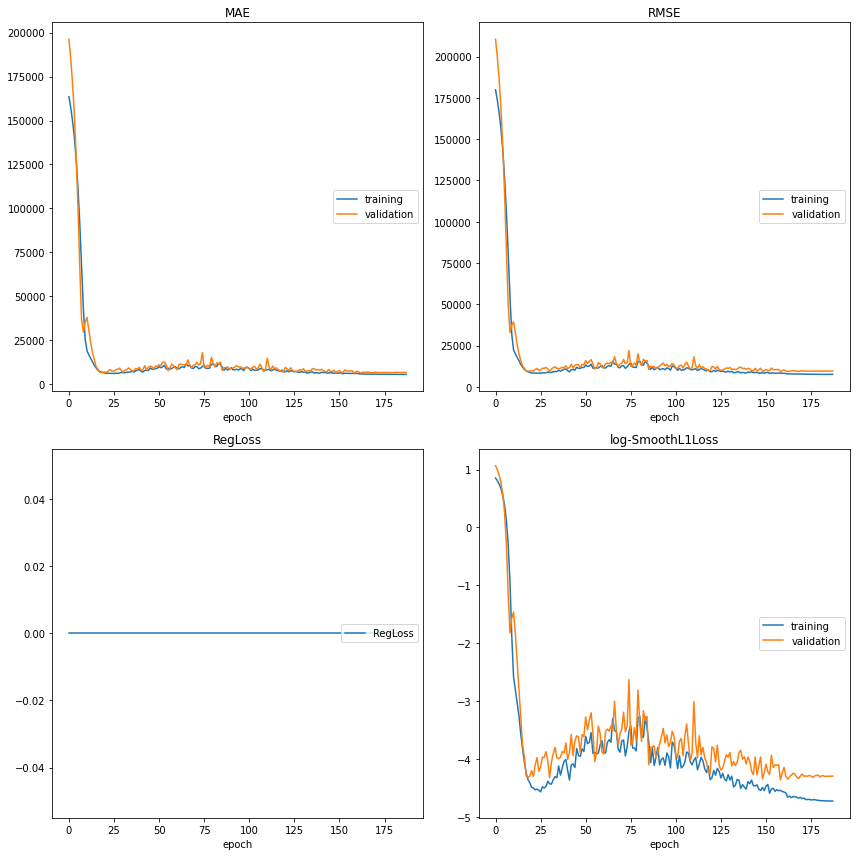

MAE
	training         	 (min: 5588.377, max: 163527.146, cur: 5588.377)
	validation       	 (min: 6401.687, max: 196274.344, cur: 6712.039)
RMSE
	training         	 (min: 7524.408, max: 179918.540, cur: 7566.666)
	validation       	 (min: 9231.172, max: 210566.484, cur: 9538.449)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	training         	 (min:   -4.726, max:    0.854, cur:   -4.726)
	validation       	 (min:   -4.361, max:    1.066, cur:   -4.296)


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
187,0.008862,5588.377174,7566.66593,0.0,0.013628,6712.039062,9538.449219


In [85]:
m = NeuralProphet()
m.add_country_holidays(country_name='Australia')
metrics = m.fit(df=train_19, freq="D",validation_df= val_19, progress="plot-all")
metrics[-1:]

## Evaluate the Model:

In [86]:
## NOTE: "make_future_dataframe" was meant to be used here

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.




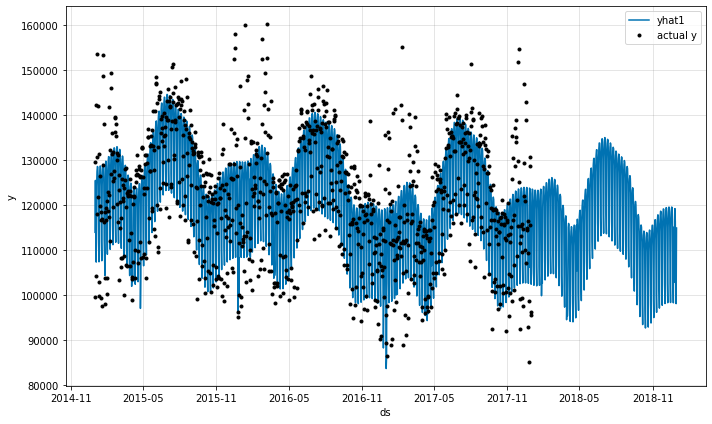

In [87]:
future = m.make_future_dataframe(df=train_19, periods=len(val_19), n_historic_predictions=True)
forecast = m.predict(df=future)
fig_forecast = m.plot(forecast)

### Epochs()
#### We will leave batch-size equal to "none" and test out a few values of epochs ranging from 5 to 500.

In [36]:
epochs_values = list(range(5,500,100))

metrics_comparison2 = []
for i in epochs_values:
    m_2 = NeuralProphet(epochs = i, batch_size = None)
    m_2.add_country_holidays(country_name='Australia')
    metrics2 = m_2.fit(df=train_19, validation_df= val_19,  freq="D")
    
    metrics_comparison2.append([i, metrics2[-1:]])
    

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.12E-01, min: 1.14E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.12E-01, min: 1.58E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.08E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s, SmoothL1Loss=0.00997, MAE=6.12e+3, RMSE=8.05e+3, RegLoss=0, MAE_val=1.13e+4, RMSE_val=1.37e+4, SmoothL1Loss_val=0.0281]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.32E-01, min: 1.58E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.32E-01, min: 1.58E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.20E-01
Epoch[105/105]: 100%|██████████| 105/105 [00:28<00:00,  3.72it/s, SmoothL1Loss=0.00887, MAE=5.59e+3, RMSE=7.49e+3, RegLoss=0, MAE_val=6.66e+3, RMSE_val=9.5e+3, SmoothL1Loss_val=0.0135] 
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.75E-02, min: 1.58E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.88E-02, min: 1.14E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.55E-02
Epoch[132/205]:  64%|██████▍   | 132/205 [00:38<00:21,  3.40it/s, SmoothL1Loss=0.0113, MAE=6.38e+3, RMSE=8.44e+3, RegLoss=0, MAE_val=6.88e+3, RMSE_val=9.44e+3, SmoothL1Loss_val=0.0133]


KeyboardInterrupt: 

In [ ]:
metrics_comparison2

In [ ]:
epochs_values3 = list(range(5,750,50))

metrics_comparison3 = []
for i in epochs_values3:
    m3 = NeuralProphet(epochs = i, batch_size = None)
    m3.add_country_holidays(country_name='Australia')
    metrics3 = m3.fit(df=train_19, validation_df= val_19, freq="D")
    
    metrics_comparison3.append([i, metrics3[-1:]])
    

In [ ]:
print(metrics_comparison3)

### Seasonality
Next we look at a set of hyperparameters that concern with seasonality of the time series. Specifically, we can decide whether the model simulates daily_seasonality(), weekly_seasonality(), or yearly_seasonality(). The model does so using Fourier series, and we can further determine how many terms we wish the series to have. Lastly, we can determine the seasonality_reg, which is a parameter that controls how much of the seasonal fluctuations the model should simulate. <br>

Since electricity demand has yearly, weekly, and daily seasonality, we will turn them on. We will then try out a series of seasonality_reg values. At this moment, we won't specify the number of terms in the Fourier series.  <br>

In [ ]:
reg_values = [0.1, 0.5, 0.75, 1, 25, 50, 75, 100]

metrics_comparison_S = []
for i in reg_values:
    m4 = NeuralProphet(seasonality_reg = i, yearly_seasonality=True, 
                      weekly_seasonality=True, daily_seasonality=True)
    m4.add_country_holidays(country_name='Australia')
    metrics4 = m4.fit(df=train_19,validation_df= val_19,  freq="D")
    
    metrics_comparison_S.append([i, metrics4[-1:]])

In [ ]:
print(metrics_comparison_S)

In [ ]:
reg_values1 = [0.1, 0.15,0.25,0.75,1, 5, 10, 15,20, 25]

metrics_comparison_S1 = []
for i in reg_values1:
    m5 = NeuralProphet(seasonality_reg = i, yearly_seasonality=True, 
                      weekly_seasonality=True, daily_seasonality=True)
    m5.add_country_holidays(country_name='Australia')
    metrics5 = m5.fit(df=train_19,validation_df= val_19,  freq="D")
    
    metrics_comparison_S1.append([i, metrics5[-1:]])

In [ ]:
print(metrics_comparison_S1)

| 0.1 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.008869 | 5595.049605  | 7555.143369| 0.000021|


| 0.15 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.008872 | 5597.978088  | 7558.706183| 0.000027|

| 0.25 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.008872 | 5592.326885 | 7533.816524 | 0.000054|

| 0.75 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.008876 | 5587.32007 | 7568.238057 | 0.000133|

| 1 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.008874 | 5600.428747 | 7579.820605 | 0.000214|

| 5 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.008876 | 5593.951735 | 7533.53305 | 0.000987|

| 10 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.008891 | 5600.639905 | 7550.379277 | 0.001379|

| 15 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.008957 | 5622.703054 | 7581.953702 | 0.003653 |

| 20 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.008999 | 5653.473027 | 7632.679648|  0.001704|

| 25 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- | 0.009077 |5687.837235 | 7631.848412 | 0.001969|

#### It seems that seasonality_reg = 0.1 is the best.

| 0.15 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.008872 | 5597.978088  | 7558.706183| 0.000027|

### learning_rate()

#### Maximum learning rate setting for 1cycle policy scheduler.

NOTE: Potentially using learning rate along , epochs and potentialy other variables(look at cell 16 on Kaggle)

In [34]:
learning_rate = [0.001,0.050,0.075,0.1,1,5,7, 10]

metrics_comparison_l = []
for i in learning_rate:
    m6 = NeuralProphet(learning_rate = i)
    m6.add_country_holidays(country_name='Australia')
    metrics6 = m6.fit(df=train_19, validation_df= val_19, freq="D")
    
    metrics_comparison_l.append([i, metrics6[-1:]])

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 188
  0%|          | 0/188 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[188/188]: 100%|██████████| 188/188 [00:43<00:00,  4.34it/s, SmoothL1Loss=0.0104, MAE=5.92e+3, RMSE=8.18e+3, RegLoss=0, MAE_val=6.67e+3, RMSE_val=9.81e+3, SmoothL1Loss_v

In [35]:
metrics_comparison_l

[[0.001,
       SmoothL1Loss          MAE        RMSE  RegLoss  SmoothL1Loss_val  \
  187      0.010358  5919.213333  8180.79772      0.0          0.014404   
  
           MAE_val     RMSE_val  
  187  6667.503906  9806.291016  ],
 [0.05,
       SmoothL1Loss          MAE         RMSE  RegLoss  SmoothL1Loss_val  \
  187      0.008878  5592.370167  7539.603639      0.0          0.013712   
  
           MAE_val    RMSE_val  
  187  6870.608887  9567.84082  ],
 [0.075,
       SmoothL1Loss          MAE         RMSE  RegLoss  SmoothL1Loss_val  \
  187      0.008872  5593.377445  7601.668985      0.0           0.01344   
  
           MAE_val     RMSE_val  
  187  6743.898438  9472.305664  ],
 [0.1,
       SmoothL1Loss          MAE         RMSE  RegLoss  SmoothL1Loss_val  \
  187      0.008869  5595.728252  7598.720047      0.0          0.013062   
  
           MAE_val     RMSE_val  
  187  6516.257324  9338.182617  ],
 [1,
       SmoothL1Loss          MAE         RMSE  RegLoss  SmoothL1Lo

[[0.001,
       SmoothL1Loss          MAE        RMSE  RegLoss  SmoothL1Loss_val  \
  187      0.010358  5919.213333  8180.79772      0.0          0.014404   
  
           MAE_val     RMSE_val  
  187  6667.503906  9806.291016  ],
 [0.05,
       SmoothL1Loss          MAE         RMSE  RegLoss  SmoothL1Loss_val  \
  187      0.008878  5592.370167  7539.603639      0.0          0.013712   
  
           MAE_val    RMSE_val  
  187  6870.608887  9567.84082  ],
 [0.075,
       SmoothL1Loss          MAE         RMSE  RegLoss  SmoothL1Loss_val  \
  187      0.008872  5593.377445  7601.668985      0.0           0.01344   
  
           MAE_val     RMSE_val  
  187  6743.898438  9472.305664  ],
 [0.1,
       SmoothL1Loss          MAE         RMSE  RegLoss  SmoothL1Loss_val  \
  187      0.008869  5595.728252  7598.720047      0.0          0.013062   
  
           MAE_val     RMSE_val  
  187  6516.257324  9338.182617  ],
 [1,
       SmoothL1Loss          MAE         RMSE  RegLoss  SmoothL1Loss_val  \
  187      0.008877  5582.901046  7559.720864      0.0           0.01322   
  
           MAE_val     RMSE_val  
  187  6652.268555  9394.600586  ],
 [5,
       SmoothL1Loss         MAE         RMSE  RegLoss  SmoothL1Loss_val  \
  187      0.008891  5599.83119  7557.682125      0.0          0.013329   
  
           MAE_val    RMSE_val  
  187  6733.375977  9433.31543  ],
 [7,
       SmoothL1Loss          MAE         RMSE  RegLoss  SmoothL1Loss_val  \
  187      0.008899  5600.158567  7530.190587      0.0          0.013504   
  
           MAE_val    RMSE_val  
  187  6786.745117  9494.84082  ],
 [10,
       SmoothL1Loss          MAE         RMSE  RegLoss  SmoothL1Loss_val  \
  187       0.00892  5600.197594  7570.743093      0.0          0.013398   
  
           MAE_val     RMSE_val  
  187  6519.757324  9457.650391  ]]

#### The results seem inconclusive. 7 seems to produce slightly better results than the rest.

[7,     SmoothL1Loss          MAE         RMSE       RegLoss    SmoothL1Loss_val  \
  187      0.008899       5600.158567  7530.190587      0.0          0.013504   
  

## trend_reg()

In [ ]:
trend_reg1 = [0.001,0.050,0.075,0.1,1,25,50,75,69,100]

metrics_comparison_trend_reg = []
for c in trend_reg1:
    m7 = NeuralProphet(trend_reg = c)
    m7.add_country_holidays(country_name='Australia')
    metrics7 = m7.fit(df=train_19, validation_df= val_19, freq="D")
    
    metrics_comparison_trend_reg.append([c, metrics7[-1:]])

In [ ]:
metrics_comparison_trend_reg

#### Outputs:

| 0.001 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.008923 | 5600.855148 | 7596.458582 | 0.000011|


| 0.05 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.009073 | 5655.857279 | 7648.171241 | 0.000529|

| 0.075 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.009056 | 5660.112454 | 7637.635236 | 0.000935|

| 0.1 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.008934 | 5592.992473 | 7566.789137 | 0.000895|

| 1 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.00904 | 5644.236428 | 7639.605804 | 0.008313|

| 25 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.009387 | 5685.893569 | 7718.940747 | 0.000002|

| 50 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.009388 | 5686.321653 | 7680.415941 | 4.905785e-07|

| 75 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.00939 | n.121614 | 7739.378724 | 7.554012e-07|

| 69 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- |0.009389 | 5690.958656 | 7747.409543 | 0.000002|

| 100 | SmoothL1Loss |   MAE |RMSE|RegLoss187|
| --- | --- | --- | --- | --- |
|--- | 0.009395 | 5689.798707 | 7780.117751 | 0.000003|

#### The best parameter out of the values we picked is trend_reg = 0.1.
0.1	SmoothL1Loss	MAE	RMSE	RegLoss187
---	0.008934	5592.992473	7566.789137	0.000895

### Adding AR-Net

In [ ]:
m8 = NeuralProphet(n_forecasts=1, n_lags=3, epochs=30, changepoints_range=0.95)
m8.add_country_holidays(country_name='Australia')
metrics8 = m8.fit(df=train_19, validation_df= val_19, freq="D")
metrics8[-1:]

### AR Net Systematic Tuning:

#### Formula: 

https://neuralprophet.com/html/forecaster.html

In [ ]:
'''
param_grid parameters:
    - num_hidden_layers(NOTE: Deafault is 0) : 1,2
    - changepoints_range : Proportion of history in which trend changepoints will be estimated.
                         e.g. set to 0.8 to allow changepoints only in the first 80% of training data. Ignored if manual changepoints list is supplied.
    - n_lags : Previous time series steps to include in auto-regression. Aka AR-order
             0, 7(1 week), 30(1 month), 180(6 months), 365(1 yr), 545(1.5 yr) 730(2 yrs)
'''
param_grid = {  
    'num_hidden_layers': [1,2],
    'changepoints_range': [0.95, 0.975, 0.99, 0.995, 0.999],
    'n_lags': [0, 7, 30, 180, 365, 545, 730]
}


In [ ]:
m8 = NeuralProphet(n_forecasts=1, n_lags=3, epochs=30, changepoints_range=0.95)
m8.add_country_holidays(country_name='Australia')
metrics8 = m8.fit(df=train_19, validation_df= val_19, freq="D")
metrics8[-1:]

In [ ]:
future = m8.make_future_dataframe(df=train_19, periods=365*3, n_historic_predictions= True )
forecast = m8.predict(df=future)
fig_forecast = m8.plot(forecast)

In [ ]:
future

In [ ]:
forecast

## Systematic Hyperparameter Tuning

#### n_lags: 1

In [103]:

# Parameter Options
param_grid_1 = {  
    'num_hidden_layers': [0,1,2,3,4,5,6,7,8],
    'changepoints_range':[0.95, 0.965, 0.975, 0.985, 0.99, 0.995,0.997, 0.999],
    'n_lags': [1]
}

# Generate all combinations of parameters
all_params_1 = [dict(zip(param_grid_1.keys(), v)) for v in itertools.product(*param_grid_1.values())]
results_1 = []  # Store the RMSEs for each params here

In [104]:
for c in all_params_1:
    m9_1 = NeuralProphet(**c, epochs = 175, learning_rate=10, seasonality_reg=0.1, trend_reg=0.1,batch_size = None)
    m9_1.add_country_holidays(country_name='Australia')
    metrics9_1 = m9_1.fit(df=train_19, validation_df= val_19, freq="D")
    
    results_1.append(dict({"RMSE_val": metrics9['RMSE_val'].min(), "RMSE_train": metrics9_1['RMSE'][metrics9_1['RMSE_val'].idxmin()], "score_epoch_number": metrics9_1['RMSE_val'].idxmin()}, **c))

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [00:37<0

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [00:28<00:00,  6.05it/s, SmoothL1Loss=0.00616, MAE=4.55e+3, RMSE=6.33e+3, RegLoss=0.00108, MAE_val=2.42e+4, RMSE_val=2.69e+4, SmoothL1Loss_val=0.109] 
INFO - (NP.config.__post_init__) - Note: Trend 

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [01:01<00:00,  2.85it/s, SmoothL1Loss=0.00915, MAE=5.69e+3, RMSE=7.69e+3, RegLoss=0.00131, MAE_val=1.57e+4, RMSE_val=1.8e+4, SmoothL1Loss_val=0.0484] 
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is e

  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [00:31<00:00,  5.63it/s, SmoothL1Loss=0.00903, MAE=5.62e+3, RMSE=7.58e+3, RegLoss=0.000512, MAE_val=6.46e+3, RMSE_val=9.39e+3, SmoothL1Loss_val=0.0132]
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily s

Epoch[175/175]: 100%|██████████| 175/175 [00:33<00:00,  5.26it/s, SmoothL1Loss=0.00949, MAE=5.81e+3, RMSE=7.83e+3, RegLoss=0.00145, MAE_val=1.13e+4, RMSE_val=1.38e+4, SmoothL1Loss_val=0.0285]
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/

INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [00:37<00:00,  4.62it/s, SmoothL1Loss=0.0091, MAE=5.65e+3, RMSE=7.67e+3, RegLoss=0.000935, MAE_val=

INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [00:38<00:00,  4.57it/s, SmoothL1Loss=0.00917, MAE=5.71e+3, RMSE=7.68e+3, RegLoss=0.000719, MAE_val=1.37e+4, RMSE_val=1.59e+4, SmoothL1Loss_val=0.0378]
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [00:45<00:00,  3.84it/s, SmoothL1Loss=0.00913, MAE=5.66e+3, RMSE=7.7e+3, RegLoss=0.000768, MAE_val=1.2e+4, RMSE_val=1.41e+4, SmoothL1Loss_val=0.0299] 
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is e

  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [01:20<00:00,  2.19it/s, SmoothL1Loss=0.00898, MAE=5.6e+3, RMSE=7.59e+3, RegLoss=0.000618, MAE_val=1.26e+4, RMSE_val=1.48e+4, SmoothL1Loss_val=0.033]  
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily s

Epoch[175/175]: 100%|██████████| 175/175 [00:41<00:00,  4.22it/s, SmoothL1Loss=0.00966, MAE=5.88e+3, RMSE=7.9e+3, RegLoss=0.0015, MAE_val=1.44e+4, RMSE_val=1.7e+4, SmoothL1Loss_val=0.0435]  


In [138]:
results_1

[{'RMSE_val': 14607.3017578125,
  'RMSE_train': 6203.5002608625855,
  'score_epoch_number': 174,
  'num_hidden_layers': 0,
  'changepoints_range': 0.95,
  'n_lags': 1},
 {'RMSE_val': 14607.3017578125,
  'RMSE_train': 7722.72178581621,
  'score_epoch_number': 163,
  'num_hidden_layers': 0,
  'changepoints_range': 0.965,
  'n_lags': 1},
 {'RMSE_val': 14607.3017578125,
  'RMSE_train': 7923.554048052226,
  'score_epoch_number': 164,
  'num_hidden_layers': 0,
  'changepoints_range': 0.975,
  'n_lags': 1},
 {'RMSE_val': 14607.3017578125,
  'RMSE_train': 6896.898878959761,
  'score_epoch_number': 167,
  'num_hidden_layers': 0,
  'changepoints_range': 0.985,
  'n_lags': 1},
 {'RMSE_val': 14607.3017578125,
  'RMSE_train': 10800.750409799515,
  'score_epoch_number': 2,
  'num_hidden_layers': 0,
  'changepoints_range': 0.99,
  'n_lags': 1},
 {'RMSE_val': 14607.3017578125,
  'RMSE_train': 6394.067297196061,
  'score_epoch_number': 169,
  'num_hidden_layers': 0,
  'changepoints_range': 0.995,
  'n_

#### Outputs:

|n_lags: 1| RMSE_val| RMSE_train|score_epoch_number|num_hidden_layers|changepoints_range|
|---| --- | --- | --- | --- | ---|
|---|14607.3017578125|6203.5002608625855|174|0|0.95|
|---|14607.3017578125|7722.72178581621|163|0|0.965|
|---|14607.3017578125|7923.554048052226|164|0|0.975|
|---|14607.3017578125|6896.898878959761|167|0|0.985|
|---|14607.3017578125|10800.750409799515|2|0|0.99|
|---|14607.3017578125|6394.067297196061|169|0| 0.995|
|---|14607.3017578125|6442.894927003068|171|0|0.997|
|---|14607.3017578125|10237.151269977168|3|0|0.999|
|---|14607.3017578125|10522.272720908248|162|1|0.95|
|---|14607.3017578125|10372.42522920234|163|1|0.965|
|---|14607.3017578125|15009.893463720035|2|1|0.975|
|---|14607.3017578125|11702.236236265697|4|1|0.985|
|---|14607.3017578125|7904.454210366724|171|1|0.99|
|---|14607.3017578125|8337.5203125|168|1|0.995|
|---|14607.3017578125|9532.145535013557|163|1|0.997|
|---|14607.3017578125|15537.847343214897|2|1|0.999|
|---|14607.3017578125|7802.51228328339|171|2|0.95|
|---|14607.3017578125|8398.69734232306|167|2|0.965|
|---|14607.3017578125|10210.128782284532|164|2|0.975|
|---|14607.3017578125|11058.126674425657|3|2|0.985|
|---|14607.3017578125|8978.491569456335|166|2|0.99|
|---|14607.3017578125|7964.251711436929|170|2|0.995|
|---|14607.3017578125|15120.498742508562|2|2|0.997|
|---|14607.3017578125|12139.975659960046|2|2|0.999|
|---|14607.3017578125|11309.97246495077|161|3|0.95|
|---|14607.3017578125|23473.30723102169|1|3|0.965|
|---|14607.3017578125|8180.107828553082|169|3|0.975|
|---|14607.3017578125|10865.253182523544|161|3|0.985|
|---|14607.3017578125|11292.644384096746|162|3|0.99|
|---|14607.3017578125|7834.572303528111|170|3|0.995|
|---|14607.3017578125|7866.609841877141|174|3|0.997|
|---|14607.3017578125|8221.079341466895|168|3|0.999|
|---|14607.3017578125|9336.876912100457|164|4|0.95|
|---|14607.3017578125|11768.33326644549|160|4|0.965|
|---|14607.3017578125|9017.506594695347|165|4|0.975|
|---|14607.3017578125|9150.537524079624|164|4|0.985|
|---|14607.3017578125|16764.59413616581|4|4|0.99|
|---|14607.3017578125|9618.9443782998|165|4|0.995|
|---|14607.3017578125|8513.134567191068|166|4|0.997|
|---|14607.3017578125|12159.208211151541|160|4|0.999|
|---|14607.3017578125|7778.408069349315|171|5|0.95|
|---|14607.3017578125|8506.207439711758|167|5|0.965|
|---|14607.3017578125|7980.581985766267|169|5|0.975|
|---|14607.3017578125|9432.680283247717|166|5|0.985|
|---|14607.3017578125|9061.451876426941|165|5|0.99|
|---|14607.3017578125|7912.961818635845|170|5|0.995|
|---|14607.3017578125|8124.8774579052515|170|5|0.997|
|---|14607.3017578125|9099.085929473458|166|5|0.999|
|---|14607.3017578125|10605.930961936358|163|6|0.95|
|---|14607.3017578125|8820.366256421234|166|6|0.965|
|---|14607.3017578125|11491.143442315924|161|6|0.975|
|---|14607.3017578125|7700.639717109018|172|6|0.985|
|---|14607.3017578125|8458.976546223957|168|6|0.99|
|---|14607.3017578125|8819.273575734875|166|6|0.995|
|---|14607.3017578125|8255.390687428653|169|6|0.997|
|---|14607.3017578125|7892.238291060217|170|6|0.999|
|---|14607.3017578125|10852.082602918093|163|7|0.95|
|---|14607.3017578125|8110.216555186929|169|7|0.965|
|---|14607.3017578125|8025.664257366581|168|7|0.975|
|---|14607.3017578125|8609.36939123145|166|7|0.985|
|---|14607.3017578125|8118.598593125714|168|7|0.99|
|---|14607.3017578125|8964.601102311644|164|7|0.995|
|---|14607.3017578125|8561.905289044664|166|7|0.997|
|---|14607.3017578125|11778.132409389269|160|7|0.999|
|---|14607.3017578125|13214.242677119008|160|8|0.95|
|---|14607.3017578125|12546.190848405395|160|8|0.965|
|---|14607.3017578125|8731.62540756992|166|8|0.975|
|---|14607.3017578125|14496.435192815354|159|8|0.985|
|---|14607.3017578125|8639.232840146975|166|8|0.99|
|---|14607.3017578125|8094.174394442066|168|8|0.995|
|---|14607.3017578125|7683.656172410103|173|8|0.997|
|---|14607.3017578125|8724.209504316495|166|8|0.999|

#### Plotting RMSE values:

In [142]:
RMSE_val1 = []
for i in range(len(results_1)):
    RMSE_val1.append(results_1[i]['RMSE_val'])
RMSE_train1 = []
for j in range(len(results_1)):
    RMSE_train1.append(results_1[j]['RMSE_train'])

In [167]:
min(RMSE_train1)

6203.5002608625855

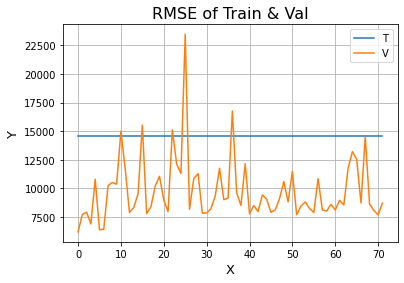

In [157]:
import matplotlib.pyplot as plt
fig = plt.figure(1)	#identifies the figure 
plt.title("RMSE of Train & Val", fontsize='16')	#title
plt.plot(RMSE_val1, label="Validation")
plt.plot(RMSE_train1, label="Train")#plot the points
plt.xlabel("X",fontsize='13')	#adds a label in the x axis
plt.ylabel("Y",fontsize='13')	#adds a label in the y axis
plt.legend(('TV')) #creates a legend to identify the plot
plt.grid()	#shows a grid under the plot
plt.show()



#### QUESTION: Why is the RMSE a solid value all across for the training set? What is a "score_epoch_number"?

When hyperparamter tuning, it appears that the following set of parameters performed the best:
    
  - 'RMSE_val': 14607.3017578125,
  - 'RMSE_train': 6203.5002608625855,
  - 'score_epoch_number': 174,
  - 'num_hidden_layers': 0,
  - 'changepoints_range': 0.95,
  - 'n_lags': 1
  
We can further observe that there is overfitting occuring. The validation set RMSE is higher than the training set RMSE. Considering that the test set contains data the model hasn't seen before, this means we potentially overfit the training set.

#### n_lags : 7

In [169]:

# Parameter Options
param_grid = {  
    'num_hidden_layers': [0,1,2,3,4,5,6,7,8],
    'changepoints_range':[0.95, 0.965, 0.975, 0.985, 0.99, 0.995,0.997, 0.999],
    'n_lags': [7]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results = []  # Store the RMSEs for each params here

In [170]:
for c in all_params:
    m9 = NeuralProphet(**c, epochs = 175, learning_rate=10, seasonality_reg=0.1, trend_reg=0.1,batch_size = None)
    m9.add_country_holidays(country_name='Australia')
    metrics9 = m9.fit(df=train_19, validation_df= val_19, freq="D")
    
    results.append(dict({"RMSE_val": metrics9['RMSE_val'].min(), "RMSE_train": metrics9['RMSE'][metrics9['RMSE_val'].idxmin()], "score_epoch_number": metrics9['RMSE_val'].idxmin()}, **c))

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [00:34<0

INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [00:55<00:00,  3.14it/s, SmoothL1Loss=0.00572, MAE=4.5e+3, RMSE=6.05e+3, RegLoss=0.00093, MAE_val=2.72e+4, RMSE_val=3.02e+4, SmoothL1Loss_val=0.136]  
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-b

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [00:33<00:00,  5.29it/s, SmoothL1Loss=0.00916, MAE=5.7e+3, RMSE=7.71e+3, RegLoss=0.000972, MAE_val=6.16e+3, RMSE_val=9.11e+3, SmoothL1Loss_val=0.0124] 
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is 

  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [00:35<00:00,  4.93it/s, SmoothL1Loss=0.00899, MAE=5.64e+3, RMSE=7.59e+3, RegLoss=0.00107, MAE_val=1.46e+4, RMSE_val=1.71e+4, SmoothL1Loss_val=0.0439]
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily se

Epoch[175/175]: 100%|██████████| 175/175 [00:34<00:00,  5.10it/s, SmoothL1Loss=0.015, MAE=6.05e+3, RMSE=9.16e+3, RegLoss=0.00109, MAE_val=7.48e+3, RMSE_val=1.3e+4, SmoothL1Loss_val=0.0208]   
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/

INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [00:37<00:00,  4.72it/s, SmoothL1Loss=0.00884, MAE=5.58e+3, RMSE=7.52e+3, RegLoss=0.0007, MAE_val=6

INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [00:49<00:00,  3.56it/s, SmoothL1Loss=0.0216, MAE=6.62e+3, RMSE=1.16e+4, RegLoss=0.00117, MAE_val=4.33e+4, RMSE_val=4.78e+4, SmoothL1Loss_val=0.329]
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-bas

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [00:40<00:00,  4.33it/s, SmoothL1Loss=0.00898, MAE=5.62e+3, RMSE=7.64e+3, RegLoss=0.00043, MAE_val=1.59e+4, RMSE_val=1.81e+4, SmoothL1Loss_val=0.0488]
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is e

  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[175/175]: 100%|██████████| 175/175 [00:46<00:00,  3.76it/s, SmoothL1Loss=0.00903, MAE=5.67e+3, RMSE=7.61e+3, RegLoss=0.000773, MAE_val=1.14e+4, RMSE_val=1.37e+4, SmoothL1Loss_val=0.028] 
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily s

Epoch[175/175]: 100%|██████████| 175/175 [00:44<00:00,  3.90it/s, SmoothL1Loss=0.00945, MAE=5.79e+3, RMSE=7.82e+3, RegLoss=0.00119, MAE_val=1.91e+4, RMSE_val=2.13e+4, SmoothL1Loss_val=0.0681]
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
  0%|          | 0/175 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/

In [171]:
results

[{'RMSE_val': 11374.7353515625,
  'RMSE_train': 13040.855522555097,
  'score_epoch_number': 161,
  'num_hidden_layers': 0,
  'changepoints_range': 0.95,
  'n_lags': 7},
 {'RMSE_val': 12808.5986328125,
  'RMSE_train': 17691.90026687328,
  'score_epoch_number': 160,
  'num_hidden_layers': 0,
  'changepoints_range': 0.965,
  'n_lags': 7},
 {'RMSE_val': 9842.5078125,
  'RMSE_train': 9829.332006140956,
  'score_epoch_number': 163,
  'num_hidden_layers': 0,
  'changepoints_range': 0.975,
  'n_lags': 7},
 {'RMSE_val': 13341.33984375,
  'RMSE_train': 10097.652992998164,
  'score_epoch_number': 173,
  'num_hidden_layers': 0,
  'changepoints_range': 0.985,
  'n_lags': 7},
 {'RMSE_val': 16069.966796875,
  'RMSE_train': 22693.950126262625,
  'score_epoch_number': 1,
  'num_hidden_layers': 0,
  'changepoints_range': 0.99,
  'n_lags': 7},
 {'RMSE_val': 17232.69140625,
  'RMSE_train': 14487.500229568412,
  'score_epoch_number': 3,
  'num_hidden_layers': 0,
  'changepoints_range': 0.995,
  'n_lags': 7

#### Outputs:

|n_lags: 7| RMSE_val| RMSE_train|score_epoch_number|num_hidden_layers|changepoints_range|
|---| --- | --- | --- | --- | ---|
|---|8709.5322265625|12211.62007862718 |159|0|0.95|
|---|24119.28515625 |13901.716009527088|4|0|0.965|
|---|11202.626953125|14251.957314623507|3|0|0.975|
|---|16251.7548828125|16802.124935433883|3|0|0.985|
|---|13316.1875|16000.6262841483|161|0|0.99|
|---|12943.9921875|14694.034047865014|3|0|0.995|
|---|8070.54150390625|10132.775066000919|164|0|0.997|
|---|11440.7080078125|6464.957658976125|170|0|0.999|
|---|15029.8447265625|22746.68739956382|3|1|0.95|
|---|14864.2236328125|16401.51991505969|3|1|0.965|
|---|8861.0556640625|8954.778437786961|165|1|0.975|
|---|9425.4697265625|7653.809465392562|173|1|0.985|
|---|9587.2197265625|8444.264864554638|169|1|0.99|
|---|11208.7451171875|8464.011162764004|169|1|0.995|
|---|11103.8642578125|11479.433568640956|165|1|0.997|
|---|12123.740234375|13026.276084710744|158|1|0.999|
|---|13346.0126953125|18159.05673926768|160|2|0.95|
|---|17352.013671875|7888.545389979339|172|2|0.965|
|---|23943.6796875|32857.728047520664|0|2|0.975|
|---|10757.7470703125|8690.35532885675|167|2|0.985|
|---|8999.845703125|11929.646600952708|169|2|0.99|
|---|9486.7919921875|8229.624174988521|170|2|0.995|
|---|12495.45703125|16228.387353650138|1|2|0.997|
|---|11429.076171875|8078.914055325987|167|2|0.999|
|---|13693.32421875|12502.210973370064|163|3|0.95|
|---|19659.615234375|28472.86362201561|155|3|0.965|
|---|13720.9306640625|14315.108212809917|163|3|0.975|
|---|11684.8564453125|9470.636887339302|167|3|0.985|
|---|9104.6767578125|7538.302233987603|174|3|0.99|
|---|9866.765625|8201.264025195132|166|3|0.995|
|---|24985.869140625|23177.163804235537|1|3|0.997|
|---|11308.3759765625|7816.581511134068|170|3|0.999|
|---|18524.94140625|17320.48382977502|4|4|0.95|
|---|12976.13671875|14488.647956841138|164|4|0.965|
|---|12814.298828125|17089.317564853078|157|4|0.975|
|---|21292.755859375|24557.826345844813|155|4|0.985|
|---|11346.1787109375|14311.025769054178|160|4|0.99|
|---|13268.70703125|7721.060627582645|172|4|0.995|
|---|11606.9970703125|9642.700657139578|169|4|0.997|
|---|11294.93359375|11118.888121269514|163|4|0.999|
|---|10672.2509765625|8442.602172291092|165|5|0.95|
|---|15155.357421875|13804.150912534435|3|5|0.965|
|---|10266.89453125|10395.792570592286|162|5|0.975|
|---|18132.193359375|14873.512138429753|3|5|0.985,|
|---|11534.7119140625|20187.754117883378|162|5|0.99|
|---|9728.3857421875|9430.050662878788|165|5|0.995|
|---|9740.8701171875|7702.300677226814|173|5|0.997|
|---|10113.9677734375|9849.101239669422|164|5|0.999|
|---|9424.3486328125|9445.628787878788|166|6|0.95|
|---|16941.71484375|12774.329975895316|3|6|0.965|
|---|10663.609375|10960.679357495408|161|6|0.975|
|---|9919.96484375|12887.50650682966|2|6|0.985|
|---|11240.2724609375|8388.212142734159|166|6|0.99|
|---|9371.677734375|8762.983829775023|167|6|0.995|
|---|16466.25|10591.723664198806|171|6|0.997|
|---|19760.892578125|25062.028731921488|1|6|0.999|
|---|17492.41015625|14155.308252984389|2| 7|0.95|
|---|10577.2001953125|18480.81172520661|2|7|0.965|
|---|22725.81640625|37400.75352244031|0|7|0.975|
|---|10664.640625|7963.561682162534|168|7|0.985,|
|---|13390.822265625|10829.414478592746|162|7|0.99|
|---|12024.0478515625|8926.373235192837|165|7|0.995|
|---|10008.1123046875|9409.651866678145|164|7| 0.997|
|---|11781.642578125|8775.059716483012|170|7|0.999|
|---|15837.6259765625|12523.02504447888|3|8|0.95|
|---|13718.5341796875|17789.849152031682|156|8| 0.965|
|---|9035.9287109375|7681.512676480716|172|8|0.975|
|---|10827.404296875|13461.35181359045|162|8|0.985|
|---|9686.7548828125|7582.221920913682|173|8|0.99|
|---|19090.66015625|25216.707902892562|1|8|0.995|
|---|12336.263671875|9780.576073232323|162|8|0.997|
|---|14607.3017578125|13776.127869605143|4|8|0.999|

#### Plotting RMSE Values:

In [172]:
RMSE_val7 = []
for i in range(len(results)):
    RMSE_val7.append(results[i]['RMSE_val'])
RMSE_train7 = []
for j in range(len(results)):
    RMSE_train7.append(results[j]['RMSE_train'])

In [176]:
print("The min RMSE for the validation set, with a lag of 7, is ", min(RMSE_val7))
print("The min RMSE for the training set, with a lag of 7, is ", min(RMSE_train7))

The min RMSE for the validation set, with a lag of 7, is  8804.2939453125
The min RMSE for the training set, with a lag of 7, is  7539.587508608815


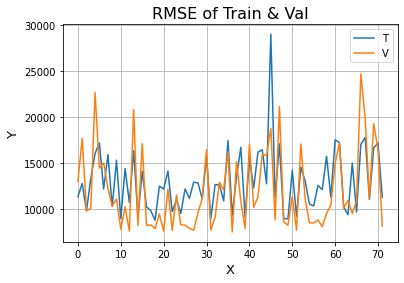

In [174]:
import matplotlib.pyplot as plt
fig = plt.figure(1) #identifies the figure 
plt.title("RMSE of Train & Val", fontsize='16') #title
plt.plot(RMSE_val7, label="Validation")
plt.plot(RMSE_train7, label="Train")#plot the points
plt.xlabel("X",fontsize='13') 
plt.ylabel("Y",fontsize='13') 
plt.legend(('TV')) #creates a legend to identify the plot
plt.grid() 
plt.show()



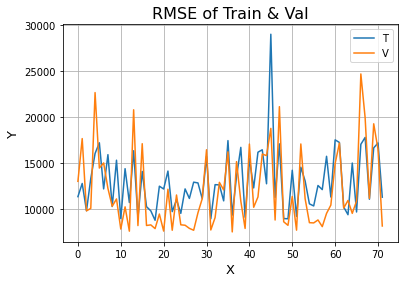

The minimum RMSE on the Validation set is 8804.2939453125:

    -'RMSE_val': 8804.2939453125
    -'RMSE_train': 7901.1406823921025
    -'score_epoch_number': 171
    -'num_hidden_layers': 2
    -'changepoints_range': 0.975
    -'n_lags': 7

 The minimum RMSE on the Training set is 7539.587508608815:

    -'RMSE_val': 9366.0625
    -'RMSE_train': 7539.587508608815
    -'score_epoch_number': 173
    -'num_hidden_layers': 4
    -'changepoints_range': 0.99
    -'n_lags': 7

-RMSE_val: 8861.0556640625	
-RMSE_train: 8954.778437786961	
-score_epoch_number: 165	
-num_hidden_layers: 1	
-changepoints_range: 0.975
-n_lags: 7

#### Visualzing Systematic Change of Hyper-parameter

In [179]:
#results["num_hidden_layers"] = results["num_hidden_layers"].astype(int)
fig_hyper = px.scatter(results, x="changepoints_range", y="RMSE_train", color = "num_hidden_layers", title='Change Point Range and RMSE_train')
fig_hyper.show()

### Observations:

In this step, we conducted systematic hyperparameter tuning on num_hidden_layers and changepoints_range. More specifically, we chose to run our model on nine different layers, starting from zero and ending at eight. For the changepoint range, we chose values 0.95, 0.965, 0.975, 0.985, 0.99, 0.995,0.997, and 0.999 in order to better visualize the effects. <br>

Through this systematic tuning, we found that the hidden layer five performs the best on our model, resulting with an RMSE on our training model of 7640.555. <br>

In [ ]:
# valid_preds = [] #list to store predictions
# lags = 3

# for d in val_19['ds'].values:
#     # getting necessary df rows

#     date_index = date_demand.index[date_demand['ds'] == d][0]
#     future = date_demand.iloc[int(date_index)-lags:int(date_index)]
    
#     # adding new row
#     entry = pd.DataFrame({
#         'ds': [d],
#         'y' : [np.nan]
#     })
#     future = pd.concat([future, entry], ignore_index = True, axis = 0)
    
#     # making prediction
#     forecast = m.predict(df=future)
#     valid_preds.append(forecast.loc[lags]['yhat1'])

## Plotting the Predictions for Validation

We will train a Neural Prophets model with the best parameters and have a look at its predictions.

In [129]:
# Training: 2015-01-01 :: 2017-12-31
# 2015 :: '2015-01-03', '2015-01-07','2015-01-18','2015-01-22','2015-02-01', '2015-02-06','2015-02-11','2015-02-20','2015-03-01','2015-03-15','2015-06-02,'2015-06-07','2015-06-14','2015-08-18','2015-09-13','2015-10-15','2015-11-19','2015-11-22','2015-12-08','2015-12-18', '2015-12-31'
# 2016 :: '2016-01-03', '2016-01-13','2016-01-19','2016-02-23','2016-03-02','2016-03-04','2016-03-08','2016-03-17','2016-05-15','2016-05-22','2016-06-27','2016-07-03','2016-11-21','2016-12-13','2016-12-29'
# 2017 :: '2017-01-03', '2017-01-06', '2017-01-07','2017-01-14','2017-01-17','2017-01-23','2017-02-09','2017-02-10','2017-02-12','2017-02-19','2017-02-25','2017-02-28','2017-03-01','2017-03-15','2017-03-20','2017-07-30','2017-08-03','2017-08-13','2017-09-03','2017-09-24','2017-11-14','2017-11-22','2017-11-30','2017-12-03','2017-12-13','2017-12-19','2017-12-25','2017-12-28'

import pandas as pd
events_df = pd.DataFrame({'event':'changepoints','ds': pd.to_datetime(['2018-01-06','2018-01-11','2018-01-14','2018-01-19','2018-01-21','2018-01-22','2018-01-23','2018-01-24','2018-01-25','2018-01-26','2018-01-27','2018-01-28','2018-01-29','2018-01-30','2018-02-07','2018-02-23','2018-02-25','2018-05-11','2018-05-16','2018-06-19','2018-06-28','2018-07-12','2018-08-05','2018-08-30','2018-11-18','2018-12-02','2018-12-07','2018-12-22','2018-12-28'])})


### TO ADD EVENT, WE MUST "create_df_with_events" for train/test/val for each run we do 
### Below we are using the entire dataset to train the model it seems(according to the example). Additionally, the dates only stem from one year
#### WILL ONLY TRAIN USING VALIDATION 

In [130]:
# NeuralProphet Object 
op = NeuralProphet(num_hidden_layers = 1,changepoints_range = 0.975, n_lags = 7, epochs = 175, learning_rate=7, seasonality_reg=0.15, trend_reg=0.1,batch_size = None,loss_func = "MSE")
# Set the model to expect the events
op = op.add_events(["changepoints"])
#Create the data df with events [TRAINING DATA W/ EVENTS]
history_df = op.create_df_with_events(val_19,events_df)
# history_dftrain = op.create_df_with_events(train_19,chng_pnts)
op.add_country_holidays(country_name='Australia')

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.


ValueError: Dataframe must have columns "ds" with the dates.

In [ ]:
#Fitting the model
metrics_op = op.fit(history_df, freq="D")

In [124]:
metrics_op[:-1]

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.208316,29732.745696,36151.411760,0.000000,0.080143,18438.689453,23160.490234
1,0.055540,15028.346031,18709.844252,0.000000,0.172929,30353.134766,34027.921875
2,0.024125,10028.449890,12532.804903,0.000000,0.024867,9982.625000,12884.680664
3,0.018404,8395.417642,10927.871456,0.000000,0.093629,23091.611328,25001.667969
4,0.035621,12091.786444,15080.641070,0.000000,0.038966,12759.752930,16129.008789
...,...,...,...,...,...,...,...
169,0.010421,6198.950700,8179.842444,0.000287,0.019564,9037.753906,11428.646484
170,0.009754,5872.791925,7937.953139,0.000294,0.021930,9557.033203,12099.769531
171,0.009132,5676.671645,7632.363105,0.000296,0.026663,11150.068359,13341.767578
172,0.009332,5768.984562,7799.356921,0.000298,0.026629,11102.108398,13333.458984


In [125]:
# Forecast with events known ahead
future = op.make_future_dataframe(df = history_df, events_df = events_df, periods = 365, n_historic_predictions = len(val_19))
forecast = op.predict(df=future)

NameError: name 'history_df' is not defined

In [128]:
events



NameError: name 'events' is not defined

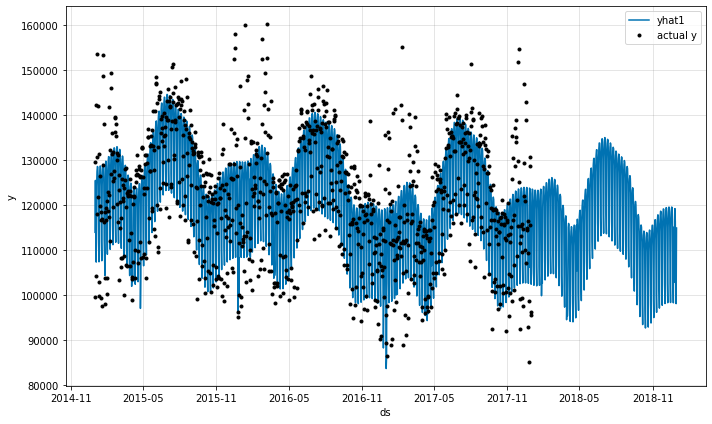

In [127]:
fig = op.plot(forecast)

## Plotting the Changepoints for Training

In [116]:
# Main Changepoints during trianing interval
# 2015 :: '2015-01-03', '2015-01-07','2015-01-18','2015-01-22','2015-02-01', '2015-02-06','2015-02-11','2015-02-20','2015-03-01','2015-03-15','2015-06-02,'2015-06-07','2015-06-14','2015-08-18','2015-09-13','2015-10-15','2015-11-19','2015-11-22','2015-12-08','2015-12-18', '2015-12-31'
# 2016 :: '2016-01-03', '2016-01-13','2016-01-19','2016-02-23','2016-03-02','2016-03-04','2016-03-08','2016-03-17','2016-05-15','2016-05-22','2016-06-27','2016-07-03','2016-11-21','2016-12-13','2016-12-29'
# 2017 :: '2017-01-03', '2017-01-06', '2017-01-07','2017-01-14','2017-01-17','2017-01-23','2017-02-09','2017-02-10','2017-02-12','2017-02-19','2017-02-25','2017-02-28','2017-03-01','2017-03-15','2017-03-20','2017-07-30','2017-08-03','2017-08-13','2017-09-03','2017-09-24','2017-11-14','2017-11-22','2017-11-30','2017-12-03','2017-12-13','2017-12-19','2017-12-25','2017-12-28'

In [119]:
import pandas as pd
#event_df
changepoint_training = pd.DataFrame({'event':'changepoints','ds': pd.to_datetime(['2015-01-03', '2015-01-07','2015-01-18','2015-01-22','2015-02-01', '2015-02-06','2015-02-11','2015-02-20','2015-03-01','2015-03-15','2015-06-02','2015-06-07','2015-06-14','2015-08-18','2015-09-13','2015-10-15','2015-11-19','2015-11-22','2015-12-08','2015-12-18', '2015-12-31','2016-01-03', '2016-01-13','2016-01-19','2016-02-23','2016-03-02','2016-03-04','2016-03-08','2016-03-17','2016-05-15','2016-05-22','2016-06-27','2016-07-03','2016-11-21','2016-12-13','2016-12-29','2017-01-03', '2017-01-06', '2017-01-07','2017-01-14','2017-01-17','2017-01-23','2017-02-09','2017-02-10','2017-02-12','2017-02-19','2017-02-25','2017-02-28','2017-03-01','2017-03-15','2017-03-20','2017-07-30','2017-08-03','2017-08-13','2017-09-03','2017-09-24','2017-11-14','2017-11-22','2017-11-30','2017-12-03','2017-12-13','2017-12-19','2017-12-25','2017-12-28'])})




In [120]:
# NeuralProphet Object 
op_train = NeuralProphet(num_hidden_layers = 1,changepoints_range = 0.975, n_lags = 7, epochs = 175, learning_rate=7, seasonality_reg=0.15, trend_reg=0.1,batch_size = None,loss_func = "MSE")
# Set the model to expect the events
op_train = op_train.add_events(["changepoints"])
#Create the data df with events [TRAINING DATA W/ EVENTS]
history_df = op_train.create_df_with_events(train_19,changepoint_training)
# history_dftrain = op.create_df_with_events(train_19,chng_pnts)
op_train.add_country_holidays(country_name='Australia')

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.


ValueError: Dataframe must have columns "ds" with the dates.

In [ ]:
#Fitting the model
metrics_op = op_train.fit(history_df, freq="D")

In [ ]:
metrics_op[:-1]

In [ ]:
# Forecast with events known ahead
future = op_train.make_future_dataframe(df = history_df, events_df = changepoint_training, periods = 365, n_historic_predictions = len(train_19))
forecast = op_train.predict(df=future)


In [ ]:
events = forecast['event_changepoints']


In [ ]:
fig = op.plot(forecast)

## Plotting RMSE Values for NeuralProphet's Hyperparameter Tuned Model 

In [50]:
RMSE_valop = []
for i in range(len(metrics_op)):
    RMSE_valop.append(metrics_op['RMSE_val'][i])
RMSE_trainop = []
for j in range(len(metrics_op)):
    RMSE_trainop.append(metrics_op['RMSE'][j])

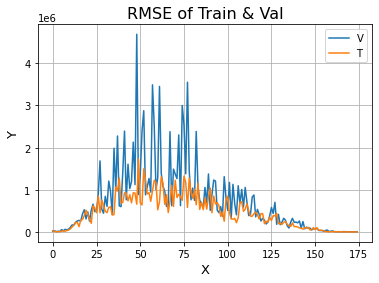

In [52]:
import matplotlib.pyplot as plt
fig = plt.figure(1) #identifies the figure 
plt.title("RMSE of Train & Val", fontsize='16') #title
plt.plot(RMSE_valop, label="Validation")
plt.plot(RMSE_trainop, label="Train")#plot the points
plt.xlabel("X",fontsize='13') 
plt.ylabel("Y",fontsize='13') 
plt.legend(('VT')) #creates a legend to identify the plot
plt.grid() 
plt.show()



In [46]:
metrics_op['RMSE'][1]

18709.8442521809

In [38]:
predicted_train = op.predict(train_19)
predicted_test = op.predict(test_19)
predicted_val = op.predict(val_19) 

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727%

In [54]:
# Create figure

# Load data
df = predicted_train

fig = go.Figure()

fig.add_trace(
    go.Scatter( x= list(df.ds), y=list(df.y),name = 'Actual Demand'))

fig.add_trace(
    go.Scatter( x= list(df.ds), y=list(df.yhat1), name = 'Predicted Demand', line=dict(color="rgba(255, 196, 118, 0.95)")))

# Set title
fig.update_layout(
    title_text="Prediction for Train"
)


# Add annotations
fig.update_layout(
    annotations=[
        dict(
            x="2016-07-01",
            y=0,
            arrowcolor="rgba(63, 81, 181, 0.2)",
            arrowsize=0.3,
            ax=0,
            ay=10,
            text="Train",
            xref="x",
            yanchor="bottom",
            yref="y")
    ],
)

fig.update_layout(
    shapes=[
        dict(
#             fillcolor="rgba(390, 81, 181, 0.2)",
            line={"width": 0},
            type="rect",
            x0="2015-01-01",
            x1="2017-12-31",
            xref="x",
            y0=0,
            y1=0.95,
            yref="paper"
        )

    ]
)

# Update axes
fig.update_layout(
    xaxis=dict(
        autorange=True,
        range=["2015-01-01", "2020-01-01"],
        rangeslider=dict(
            autorange=True,
            range=["2015-01-01", "2020-01-01"]
        ),
        type="date"
    ),
    yaxis=dict(
        anchor="x",
        #autorange=True,
        domain=[0, 1],
        linecolor="#795548",
        mirror=True,
        range=[70000, 170000],
        showline=True,
        side="right",
        tickfont={"color": "#795548"},
        tickmode="auto",
        ticks="",
        title="electricity demand",
        titlefont={"color": "#795548"},
        type="linear",
        zeroline=False
    )

)

# Update layout
fig.update_layout(
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    )
)

##  Comparison with Classical Techniques

To dos: <br>
Research Classical techniques for forecasting and pick (2) other models to compare to.<br>
Research the ones below and understand the code.

### Predict Last Value

In [ ]:
# Last Value Method
last_val_df = demand_df.copy()

last_val_df['y_prev'] = last_val_df['y'].shift(1)
last_val_df = last_val_df[last_val_df['ds'].isin(df_test['ds'].values)]
last_val_preds = last_val_df['y'].values

last_val_rmse = mean_squared_error(last_val_preds, last_val_df['y_prev'], squared=False)
last_val_rmse

----------------------

Jennifer's mess:

---------------------

## Simple Exponential Smoothing

Exponential smoothing is a forecasting method for univariate time series data. Another alternative is Holt's Exponential Smoothing, but this method can prove to be problamatic for long forecasting horizons. This method, Simple Exponential Smoothing, produces forecasts that are weighted averages of past observations where the weights of older observations exponentially decrease.

A widely preferred class of statistical techniques and procedures for discrete time series data, exponential smoothing is used to forecast the immediate future. This method supports time series data with seasonal components, or say, systematic trends where it used past observations to make anticipations.


The exponential smoothing model allows you to analyze data from specific periods of time by focusing less on older data and more on the latest data. This produces “smoothed data,” making trends and patterns more visible.

### Question posed: 
    - Can Exponential Smoothing, an algorithm that takes seasonality into account, outperform NeuralProphet?

### Creating Copies of Train | Test | Validation

In [22]:
# Create copy of data to prevent overwritting
train_19 = train_19.copy()
test_19 = test_19.copy()
val_19 = val_19.copy()

In [23]:
data1 = data.copy()
data1

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,date1
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y,2015-01-01
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N,2015-01-02
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N,2015-01-03
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N,2015-01-04
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N,2015-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,N,N,2020-10-02
2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,N,N,2020-10-03
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,N,N,2020-10-04
2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,N,N,2020-10-05


In [24]:
datac = data1[['date','demand']].rename(columns={"date": "ds", "demand": "y"})
datac



,ds,y
0,2015-01-01,99635.030
1,2015-01-02,129606.010
2,2015-01-03,142300.540
3,2015-01-04,104330.715
4,2015-01-05,118132.200
...,...,...
2101,2020-10-02,99585.835
2102,2020-10-03,92277.025
2103,2020-10-04,94081.565
2104,2020-10-05,113610.030


In [25]:
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error

exp_smooth_preds = []
for d in test_19['ds'].values:
    data_index = datac.index[datac['ds'] == d][0]
    future = datac.iloc[data_index - len(train_19): data_index]
    future = future.set_index('ds')
    future.index = pd.DatetimeIndex(future.index.values, freq = 'D')
    
    #Make Predictions
    fit = SimpleExpSmoothing(future, initialization_method = 'heuristic').fit(smoothing_level = 0.2, optimized = False)
    exp_smooth_preds.append(fit.forecast(1).values[0])
exp_smooth_rmse = mean_squared_error(test_19['y'], exp_smooth_preds, squared = False)
exp_smooth_rmse
    
    

11709.37232467103

### Results: 
    - If we compare the output RMSE to the AR-Net, we can see that the the RMSE for the AR-Net was 5933.490084 and the RMSE for Exponential Smoothing is 11709.37. We can see that NeuralProphet still outperforms.
    - Additionally, the hyper parameter tuned NeuralProphet model has an RMSE of 7640.555, whereas the Exponential Smoothing still has a higher RMSE of 11709.37.

## Using Fourier Transformation

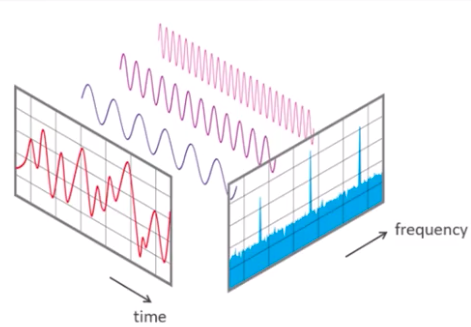

A Fourier Transformation moves us from the time domain to frequency domain. With large timeseries data, it can be difficult to see whether seasonality is present. Rather than taking Seasonality as a given, Fourier Transformations can allow us to visually see that seasonality trends exist.

If we want to describe a signal, we need three things :

    1) The frequency of the signal which shows, how many occurrences in the period we have.
    2) Amplitude which shows the height of the signal or in other terms the strength of the signal.
    3) Phase shift as to where does the signal starts
We can observe our Fourier Transformations to identify stationary or non-stationary trends. 

Text(0.5, 0, '#Cycles in full window of data(~5 years)')

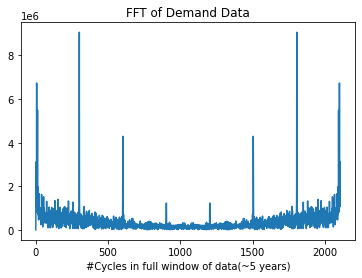

In [26]:
from scipy.fftpack import fft
import numpy as np
import matplotlib.pyplot as plt

fft = fft((datac['y']- datac['y'].mean()).values)
plt.plot(np.abs(fft))
plt.title("FFT of Demand Data")
plt.xlabel('#Cycles in full window of data(~5 years)')

### Hypothesis Test:

In the graph, we can see that some of these areas are very condensed, and the pattern can be interpreted as pontentially being flat, or trend stationary. We can run a quick hypothesis test to check whether the series is trend stationarity.

We will now test the following hypothesis :

    - HO: The time series is trend stationary.
    - HA: The time series is not trend stationary.

In [27]:
from statsmodels.tsa.stattools import kpss
import numpy as np
print(" > Is the data stationary ?")
dftest = kpss(np.log(datac.y), 'ct')
dftest
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))

WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1843: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"


WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.





 > Is the data stationary ?
Test statistic = 0.061
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


The p-value is 0.100. Since this value is not less than 0.05, we fail to reject the null hypothesis of the KPSS test. 

In other words, we can assume that the time series is trend stationary.

What and why "trend stationary"?
  - When forecasting or predicting the future, most time series models assume that each point is independent of one another. The best indication of this is when the dataset of past instances is stationary. For data to be stationary, the statistical properties of a system do not change over time. This does not mean that the values for each data point have to be the same, but the overall behavior of the data should remain constant. 


What that effectively means to us is, the test may not necessarily reject the null hypothesis (that the series is stationary) even if a series is steadily increasing or decreasing.

The word ‘deterministic’ implies the slope of the trend in the series does not change permanently. That is, even if the series goes through a shock, it tends to regain its original path.

Considering that the data is on energy demand, it makes sense that energy trends tend to regain its original path.

Source that complimnts outcome of hypothesis and of the graph : 
- https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/
- https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

   - AKA: This is GOOD !
   
 

## ARIMA

Knowing that ARIMA can only be used on stationary data. Furthermore, this model is used to forecast stationary time series. ARIMA models are made of three parts: 

    - A weighted sum of lagged values of the series(Auto-regressive(AR) part)
    - A weighted sum of lagged forecasted errors of the series(Moving-average(MA) part)
    - A difference of the time series(Integrated(I) part)

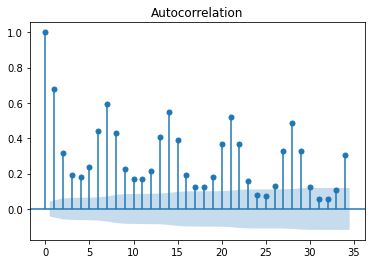

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
#data["diff"].iloc[0] = 0
plot_acf(datac.y)
plt.show()

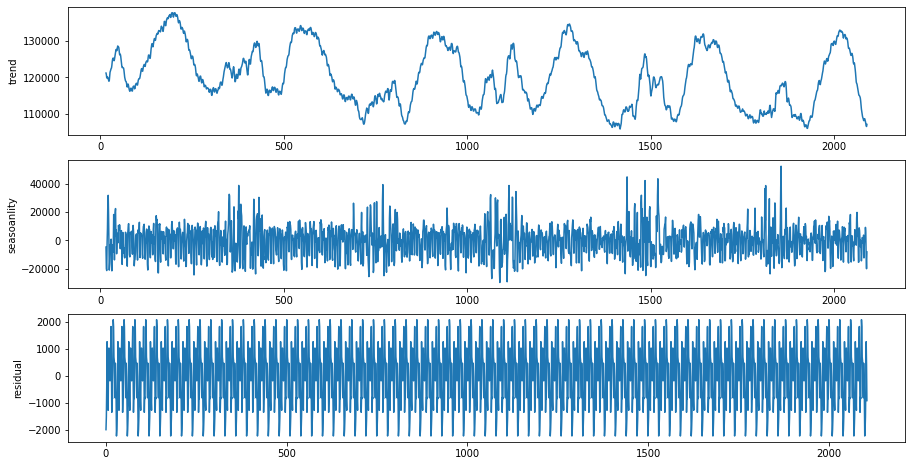

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(datac.y, model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

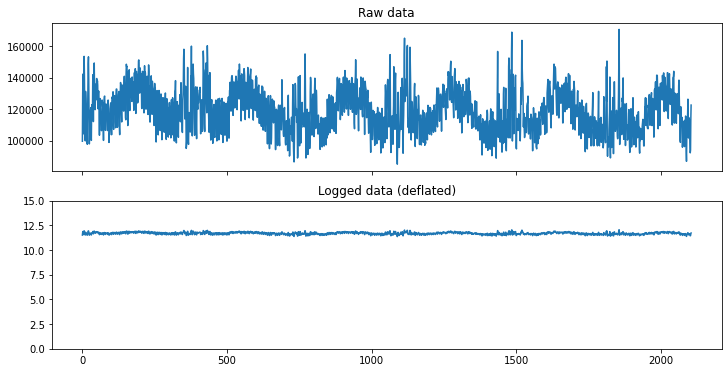

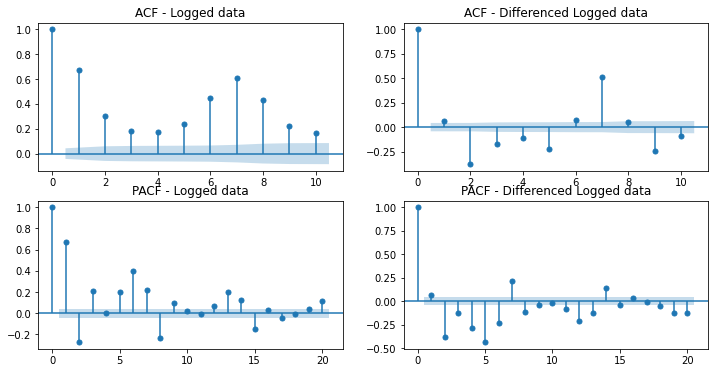

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, sharex=True, figsize=(12,6))
ax[0].plot(datac.y.values);
ax[0].set_title("Raw data");
ax[1].plot(np.log(datac.y.values));
ax[1].set_title("Logged data (deflated)");
ax[1].set_ylim(0, 15);

fig, ax = plt.subplots(2, 2, figsize=(12,6))
first_diff = (np.log(datac.y)- np.log(datac.y).shift()).dropna()
ax[0, 0] = plot_acf(np.log(datac.y), ax=ax[0, 0], lags=10, title="ACF - Logged data")
ax[1, 0] = plot_pacf(np.log(datac.y), ax=ax[1, 0], lags=20, title="PACF - Logged data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=10, title="ACF - Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=20, title="PACF - Differenced Logged data")

How to read ACF Plots:

ACF Plots start at lags = 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

Furthermore, you will see a blue area in the ACF and PACF plots, which depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

    - P: Lag 1 and lag 7 have the strongest correlation for ACF- Logged Data
    - D: 0
        - The number of times that the raw observations are 
          differenced, also called the degree of differencing; 
          Since the data is aleady stationary, it;s 0.
    - Q: 1 
        - The size of the moving average window, also called the order of moving average.

In [31]:
datac.y

0        99635.030
1       129606.010
2       142300.540
3       104330.715
4       118132.200
           ...    
2101     99585.835
2102     92277.025
2103     94081.565
2104    113610.030
2105    122607.560
Name: y, Length: 2106, dtype: float64

In [90]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(year_15_19.demand, order=(7,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)



WARNING - (py.warnings._showwarnmsg) - /Users/jenniferrodrigueztrujillo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_mode

                              ARMA Model Results                              
Dep. Variable:                 demand   No. Observations:                 1826
Model:                     ARMA(7, 1)   Log Likelihood              -19078.826
Method:                       css-mle   S.D. of innovations           8339.510
Date:                Sun, 31 Jul 2022   AIC                          38177.651
Time:                        07:41:45   BIC                          38232.750
Sample:                    01-01-2015   HQIC                         38197.976
                         - 12-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.205e+05   1435.865     83.902      0.000    1.18e+05    1.23e+05
ar.L1.demand     0.2336      0.044      5.366      0.000       0.148       0.319
ar.L2.demand     0.0497      0.040      1.25

#### Plotting Method #1:

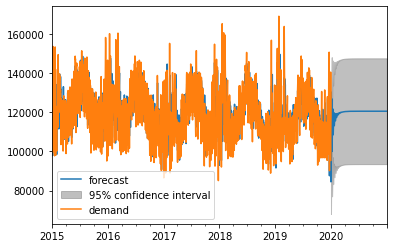

In [94]:
# model_fit.plot_predict(start='2015-01-01',end='2020-12-31')
ARIMA_plot = model_fit.plot_predict(start='2015-01-01',end='2020-12-31')


Resources:
  - https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf

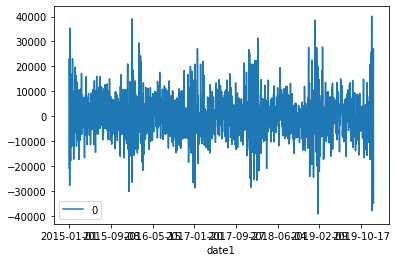

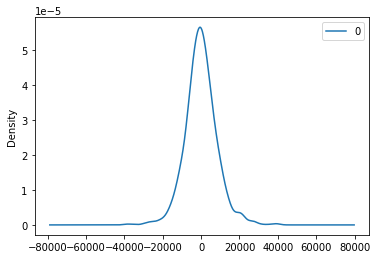

                  0
count   1826.000000
mean     -17.498262
std     8370.366808
min   -39249.265150
25%    -4862.658060
50%     -272.595850
75%     4486.470519
max    40116.691940


In [97]:
from pandas import DataFrame
from matplotlib import pyplot
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

Jennifer's Mess Ends

-------------------------------------------------

#### Side Info/ Examples of models

### SARIMA

In [ ]:
!pip install pmdarima --quiet
import pmdarima as pm

# Seasonal - Find best parameters with Auto-ARIMA
SARIMA_model = pm.auto_arima(df_train["y"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=7, #weekly frequency
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
SARIMA_model

In [ ]:
%%time
# SARIMA Method
from statsmodels.tsa.arima.model import ARIMA

sarima_preds = []

for d in df_test['ds'].values:
    # Setting up dataframe
    date_index = demand_df.index[demand_df['ds'] == d][0]
    future = demand_df.iloc[date_index-len(df_train):date_index]
    future = future.set_index('ds')
    future.index = pd.DatetimeIndex(future.index.values, freq='D')
       # Fit model + make predictions
    m_sarima = ARIMA(future['y'], order=(1,0,1), seasonal_order=(0, 1, 1, 7)).fit()
    sarima_preds.append(m_sarima.forecast(1).values[0])
    
sarima_rmse = mean_squared_error(df_test['y'], sarima_preds, squared=False)
sarima_rmse

In [ ]:
m = NeuralProphet(newer_samples_weight=5, n_forecasts=1, n_lags=3, learning_rate=0.02, epochs=25, batch_size=32, num_hidden_layers=1, changepoints_range=0.995)
m.add_country_holidays(country_name='Australia')
metrics6 = m.fit(df=df_train, freq="D")

neuralprophet_preds = [] #list to store predictions
lags = 3

for d in df_test['ds'].values:
    # getting necessary df rows
    date_index = demand_df.index[demand_df['ds'] == d][0]
    future = demand_df.iloc[date_index-lags:date_index]
      # adding new row
    entry = pd.DataFrame({
        'ds': [d],
        'y' : [np.nan]
    })
    future = pd.concat([future, entry], ignore_index = True, axis = 0)
    
    # making prediction
    forecast = m.predict(df=future)
    neuralprophet_preds.append(forecast.loc[lags]['yhat1'])
    
neuralprophet_rmse = mean_squared_error(df_test['y'], neuralprophet_preds, squared=False)


In [ ]:
def comparison_plot():
    """Visualizing the training + validation sets"""
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_title("Model Comparison")
    ax.plot(df_test["y"].values,'.k', label='True Value')
    ax.plot(last_val_preds, label="Last Value")
    ax.plot(exp_smooth_preds, label="Exponential Smoothing")
    ax.plot(sarima_preds, label="SARIMA")
    ax.plot(neuralprophet_preds, label="NeuralProphet")
    ax.legend()
    plt.show()
        
def score_plot():
    """Visualizing the training + validation sets"""
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    
    scores = {
        "Last Value": last_val_rmse,
        "Exponential Smoothing": exp_smooth_rmse,
        "SARIMA": sarima_rmse,
        "NeuralProphet": neuralprophet_rmse,
    }
    ax.set_title("Score Plot")
    ax.bar(scores.keys(), scores.values())
    ax.bar_label(ax.containers[0], label_type='edge')
    ax.margins(y=0.1)
    plt.show()
    
comparison_plot()
score_plot()